In [1]:
import pandas as pd
import io
import os
from tqdm import tqdm
import time
import numpy as np
import random
import scipy
from sklearn.decomposition import TruncatedSVD
import sys
import math

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations, filterfalse
from itertools import groupby

In [8]:
from enum import Enum

class SVDManager:
    def __init__(self, x, y, z, embedding_dim):
        self.embedding_dim = embedding_dim

        self.U, self.S, self.Vt = x, y, z
    
    def rank_one_update(self, a, b):
        #######################
        #####   EQNs (6)  #####
        #######################

        m = np.dot(self.U.T, a)
        p = a - np.dot(self.U, m)
        Ra = np.linalg.norm(p)
        P = p / (Ra + np.finfo(np.float32).eps)

        #######################
        #####   EQNs (7)  #####
        #######################

        n = np.dot(self.Vt, b)
        q = b - np.dot(self.Vt.T, n)
        Rb = np.linalg.norm(q)
        Q = q / (Rb + np.finfo(np.float32).eps)

        #######################
        #####   EQN (8)   #####
        #######################

        K = np.zeros((self.U.T.shape[0] + 1, self.Vt.shape[0] + 1))
        K[:self.S.shape[0], :self.S.shape[0]] = self.S * np.eye(self.S.shape[0])

        mp = np.concatenate((m, [np.linalg.norm(p)])).reshape(-1, 1)
        nq = np.concatenate((n, [np.linalg.norm(q)])).reshape(1, -1)

        tmp = np.dot(mp, nq)
        K = K + tmp

        #######################
        #####   EQN (5)   #####
        #######################

        U_P = np.concatenate((self.U.T, P.reshape(1, -1)))
        V_Q = np.concatenate((self.Vt, Q.reshape(1, -1)))

        Up, Sp, VpT = scipy.linalg.svd(K)

        new_U = np.dot(U_P.T, np.linalg.inv(Up.T))
        new_S = Sp
        new_V = np.dot(V_Q.T, np.linalg.inv(VpT))

        self.U = new_U[:, :self.embedding_dim]
        self.S = new_S[:self.embedding_dim]
        self.Vt = new_V.T[:self.embedding_dim, :]
        
    def add_column(self, col):
        self.Vt = np.hstack((self.Vt, np.zeros((self.Vt.shape[0], 1))))
        self.rank_one_update(col, np.concatenate((np.zeros(self.Vt.shape[1] - 1), [1])))
    
    def add_row(self, row):
        self.U = np.vstack((self.U, np.zeros(self.U.shape[1])))
        self.rank_one_update(np.concatenate((np.zeros(self.U.shape[0] - 1), [1])), row)

    def get_book_vector(self, user_id):
        index = self.book_repo[user_id]
        return np.dot(self.U, np.dot(self.S * np.eye(self.embedding_dim), self.Vt[:, index]))
    
    def get_user_vector(self, attribute):
        index = self.user_repo[attribute]
        return np.dot(np.dot(self.U[index, :], self.S * np.eye(self.embedding_dim)), self.Vt)


In [2]:
org_mat = scipy.sparse.random(10000, 10000, density=0.01, format='coo', dtype=None, random_state=None, data_rvs=None).toarray()

In [3]:
mod_mat = np.vstack((org_mat, np.zeros(org_mat.shape[1])))

In [4]:
x, y, z = scipy.linalg.svd(org_mat)

In [5]:
dimension_list = [10, 100, 500, 1000, 5000]

In [10]:
svdm_list = []

In [11]:
for d in tqdm(dimension_list):
    svdm = SVDManager(x, y, z, d)
    svdm.add_row(np.zeros(svdm.Vt.shape[1]))
    svdm_list.append(svdm)
    diff = mod_mat - np.dot(svdm.U, np.dot(svdm.S * np.eye(svdm.embedding_dim), svdm.Vt))
    print("FOR EMBEDDING", svdm.embedding_dim, "ERROR", np.max(diff))

 20%|██        | 1/5 [10:29<41:58, 629.54s/it]

FOR EMBEDDING 10 ERROR 1.0020321886887504


 40%|████      | 2/5 [19:31<28:53, 577.82s/it]

FOR EMBEDDING 100 ERROR 0.993113840395598


 60%|██████    | 3/5 [27:40<17:55, 537.58s/it]

FOR EMBEDDING 500 ERROR 0.9477523807567383


 80%|████████  | 4/5 [36:00<08:42, 522.54s/it]

FOR EMBEDDING 1000 ERROR 0.8854118416758812


100%|██████████| 5/5 [45:28<00:00, 545.74s/it]

FOR EMBEDDING 5000 ERROR 0.3400174971995714


In [12]:
for svdm in tqdm(svdm_list):
    diff = mod_mat - np.dot(svdm.U, np.dot(svdm.S * np.eye(svdm.embedding_dim), svdm.Vt))
    print("FOR EMBEDDING", svdm.embedding_dim, "ERROR", np.average(diff))

 20%|██        | 1/5 [00:14<00:56, 14.12s/it]

FOR EMBEDDING 10 ERROR 1.9028434843124607e-06


 40%|████      | 2/5 [00:19<00:26,  8.89s/it]

FOR EMBEDDING 100 ERROR 1.8295674084728176e-06


 60%|██████    | 3/5 [00:29<00:18,  9.46s/it]

FOR EMBEDDING 500 ERROR 1.5754141325365456e-06


 80%|████████  | 4/5 [00:42<00:10, 10.97s/it]

FOR EMBEDDING 1000 ERROR 1.3242789397393491e-06


100%|██████████| 5/5 [01:20<00:00, 16.04s/it]

FOR EMBEDDING 5000 ERROR 2.1351257664646945e-07


In [16]:
for svdm in tqdm(svdm_list):
    siz = (len(pickle.dumps(svdm.U)) + len(pickle.dumps(svdm.S)) + len(pickle.dumps(svdm.Vt))) / len(pickle.dumps(mod_mat))
    print("FOR SIZE", d, "DISK", siz)

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

FOR SIZE 5000 DISK 0.0020005882910532364
FOR SIZE 5000 DISK 0.02000058844103821


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

FOR SIZE 5000 DISK 0.10000057619226553
FOR SIZE 

 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

5000 DISK 0.20000055619426935


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

FOR SIZE 5000 DISK 1.0000003962102997


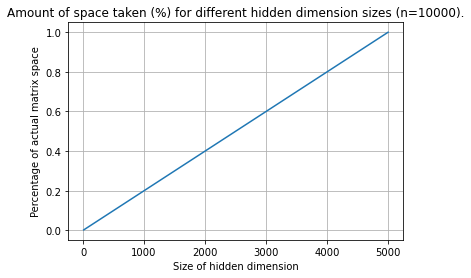

In [24]:
save_percent = [(10, 0.0020005882910532364), (100, 0.02000058844103821), (500, 0.10000057619226553), (1000, 0.20000055619426935), (5000, 1.0000003962102997)]
graph = sns.lineplot(x = list(map(lambda x: x[0], save_percent)), y = list(map(lambda x: x[1], save_percent)), ci = None)
graph.grid(True)
graph.set_title("Amount of space taken (%) for different hidden dimension sizes (n=10000).")
graph.set_ylabel("Percentage of actual matrix space")
graph.set_xlabel("Size of hidden dimension")
plt.show()

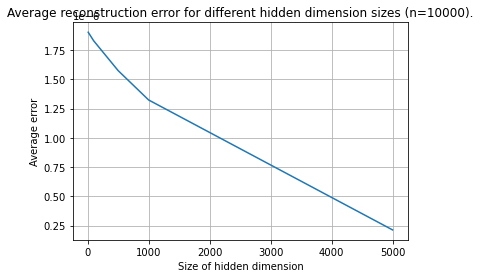

In [25]:
save_percent = [(10, 1.9028434843124607e-06), (100, 1.8295674084728176e-06), (500, 1.5754141325365456e-06), (1000, 1.3242789397393491e-06), (5000, 2.1351257664646945e-07)]
graph = sns.lineplot(x = list(map(lambda x: x[0], save_percent)), y = list(map(lambda x: x[1], save_percent)), ci = None)
graph.grid(True)
graph.set_title("Average reconstruction error for different hidden dimension sizes (n=10000).")
graph.set_ylabel("Average error")
graph.set_xlabel("Size of hidden dimension")
plt.show()

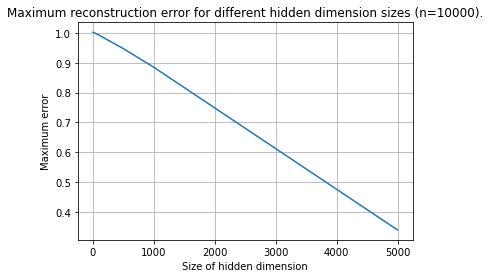

In [26]:
save_percent = [(10, 1.0020321886887504), (100, 0.993113840395598), (500, 0.9477523807567383), (1000, 0.8854118416758812), (5000, 0.3400174971995714)]
graph = sns.lineplot(x = list(map(lambda x: x[0], save_percent)), y = list(map(lambda x: x[1], save_percent)), ci = None)
graph.grid(True)
graph.set_title("Maximum reconstruction error for different hidden dimension sizes (n=10000).")
graph.set_ylabel("Maximum error")
graph.set_xlabel("Size of hidden dimension")
plt.show()